
*I am grateful to many of the faculty at the University of Oregon whom have helped me understand this. Specifically, I am grateful to [Mark Colas](https://sites.google.com/site/markyaucolas/home) for all of the guidance. Additonally, I would like to thank [Grant Mcdermott](http://grantmcdermott.com/) for his wonderful [course](https://github.com/uo-ec607-2019winter/lectures) that has helped in numerous ways. Any errors are my own.*

# Introduction


I have found there are many resources online for learning about finite horizon discrete dynamic choice models. However, there are few resources for going through an example with code. I intend on posting roughly three set of notes regarding this topic. They will be structured as follows

1. Solving discrete dynamic choice models in partial equilibrium: set-up and examples (this set of notes)

2. Extensions to 1. (expanding the state-space, distributional assumptions, maybe monte-carlo integration)

3. General equilibrium discrete-dynamic choice models: set-up and examples.

# The Setup

I now walk through the set-up of the general problem. This essentially an annotation of [Lee 2005](https://onlinelibrary.wiley.com/doi/full/10.1111/j.0020-6598.2005.00308.x). 

## Decision Problem

Consider an agent chosing between $z$ alternatives, where $z$ is finite. The agent lives for $T$ periods. Let $S(a)$ denote the current set of state variables at age $a$. The decision problem can be stated as:

\begin{align*}
V(\boldsymbol{S}(a),a) &= \max_{ \{d_z(a)\}_{\tau=a}^T } E \left [ \sum_{\tau = a}^T \beta^{\tau -a} u(a) | S(a)  \right ]\\
u(a) &= \sum_z d_z(a) u_z(a)
\end{align*}

where $d_z(t)$ is an indicator that is one if the individual chooses alternative $z$, $u_z$ is the utility associated with that alternative and $\beta$ is the subjective discount rate. In words, this says that the agent needs to pick a sequence of $z$'s that maximize the present-value of lifetime utility. We can write the value function as the maximum over alternative specific value functions:

\begin{align*}
V(\boldsymbol{S}(a),a) = \max_{z \in Z} \{ V_z(\boldsymbol{S}(a), a) \}
\end{align*}
 
where $V_z(\boldsymbol{S}(a), a)$ is the alternative-specific value function. Note that because the agent has a finite life, we can write the alternative specific value function in the following way:


\begin{align*}
V_z((\boldsymbol{S}(a), a) = 
\begin{cases} 
     v(\cdot | S(a)) +  \beta E \left [  V_z(\boldsymbol{S}(a+1), a+1) | \boldsymbol{S}(a) \right  ]  & a < T\\
     &\\
      V_z((\boldsymbol{S}(a), a)& a = T \\
   \end{cases}
\end{align*}



The formulation above of the alternative specific value function hinges on the fact that in the terminal period there is no continuation value. The optimal sequence of location choices is given by:

\[  z_a^* = argmax_z V(S(a)) \]



## The Emax Function

Define the $Emax$ function as the expected continuation value over the stochastic shocks:

\[Emax(S(a))=E\left[ V(S(a) \right ]\\
\int_{-\infty}^{+\infty}\max_z[V_z(S(a))]dF(\varepsilon)  \]

where $F(\varepsilon)$ is the cumulative density function of $\varepsilon$. As mentioned abve the agent has a finite life so we can write:

\begin{align*}
V_z(T) = v_z(S(T))\\
Emax(S(T))= E \left [ \max_z(u_z(S(T))) \right ]
\end{align*}

After we compute $Emax(S(T))$ we can recursively determine the sequence of Emax functions as

\begin{align*}

Emax(S(T-1)) &= E[\max_z V_z(S(T-1))] \\
&=E[\max_z[u_z+\beta Emax(S_z(T))]]
\end{align*}

Note that in the initial step, we have already calculated $Emax(S_z(T))$ for each alternative. Thus we can subsequently determine the entire sequence until we get to the current period.

# An Example

Most posts I have found online have abstracted from a concrete example with code. Here I will walk through an example with an implementation of the alogrithm.


## Model

Consider a model in which an agent is making a decision as to where to live. This model will be similar to the static framework first discussed by Rosen (1984) but we will add dynamics. For simplicity, assume that there are only two locations $z=1$ or $z=2$. These locations can vary by wages, rents and a stochastic shock. We will solve a partial equilibrium version of the model (for now) and hence fix wages and rents.


The agent lives for T periods, and is endowed with an initial location, which we will denote as $z_0$. They care about consumption of a numeaire good and rental prices. If the agent wants to move they must pay a monetary cost[^1], which we will denote $c$. Additionally, each agent receives an idiosyncratic shock, $\varepsilon$ each period. Assume that this shock is distributed extreme-value type 1 (EV1).

## Flow Utility

An optimizing agent will consume the utility maximizing bundle of the consumption good and housing regardless of the location. Hence we can view the agent as choosing a location to maximize utility, taking consumption and housing as given. Suppose the agent has cobb-douglas preferences. Then the static maximization (not conditional on location) problem is:


\[\max_{C,H} C^{\alpha_c}H^{\alpha_h}\exp(\varepsilon)\\
s.t\\
C+R*H \leq W\]

Solving the maximization problem is straightforward. The optimal quantities of consumption and housing are given by:

\[C^* =\alpha_cW, \hspace{.2in} H^* = \frac{\alpha_h}{R}W \]

This yields the indirect utility function

\[v = (\alpha_c+\alpha_h) w-\alpha_h r+ \varepsilon \]

where lower-cased variables are in logs. Note that the agent's location choice does not change the consumption and housing demand functions, rather it impacts the values (wages and rents vary across cities). Location has another impact though when we consider dynamics; if the agent moves, they must pay a cost. Incorporating moving costs, we can write the indirect utility function (henceforth flow utility) for individual $i$ in city $z$ at age $a$ as

\[v_{iza} =  \begin{cases} 
(\alpha_c+\alpha_h) w_z-\alpha_h r_z+\varepsilon_{iza} & \hspace{.2in} \text{if}\hspace{.2in} z_{i,a}= z_{i,a-1}\\
(\alpha_c+\alpha_h)(w_z-c)-\alpha_hr_z +\varepsilon_{iza} & \hspace{.2in} \text{if}\hspace{.2in} z_{i,a}\neq z_{i,a-1}\\
\end{cases}
\]

From here on, lets assume $\alpha_c+\alpha_h=1$. Also note that the state space at age a is $S(a) = \{Z(a-1), \varepsilon(a)  \}$. In general the econometrician cannot observe $\varepsilon(a)$.




# Algorithm

## Overview

I now turn toward simulating the model. In the partial equilibrium set up, this can be broken down into two main steps:

0. Calibrate the model (set wages, rents, etc)

1. Solve for Emax given parameter values, recursively.

  - Note: Here we actually solve for Emax because under the EV1 assumption, this has a closed form.

2. Simulate choices

  - Note: In this step we are *simulating* choices because we are drawing values of $\varepsilon$ each period.



### Stage 1

Given our assumption about $\varepsilon$, Emax has a closed for each period.[^2] Specifically, we can write:

$$Emax = \log \left ( \sum_{z}\exp(\bar{V}_z)   \right ) $$

Where $\bar{V}_m$ is the deterministic part of the value of alternative $z$.  Note that in general $Emax \in \mathbb{R}^z$: there is a continuation value for each alternative. This will become more clear with an example.   

To calculate Emax, we can start in the final period and roll back until the current period. Note that is is useful to denote:

$$v_{iza} = \tilde{v}_{iza}+\varepsilon_{iza} $$


To initialize the alogirithm:


1. **Period t = T**
In the final decision period, 
\begin{align*}
	&Emax(\mathbf{S}(T)) = E [ max_{z}u_z(\mathbf{S}(T))]\\
	\\&=\left [ \begin{array}{c}
	\log(\exp(w_1-\alpha_hr_1)+\exp((w_2-c)-\alpha_hr_2))\\
	\log(\exp((w_1-c)-\alpha_hr_1)+\exp(w_2-\alpha_hr_2))
	\end{array} \right ]
\end{align*}
	
2. **Period t = T-1**
	
We now move onto the next stage: period T-1. We can calculate 
	
\begin{align*}
	&	Emax(\mathbf{S}(T-1)) = E [max_z[ u_z + \beta Emax((\mathbf{S}_z(T))]]]\\
		\\=&\left [
		\begin{array}{c}
		\log(\exp(w_1-\alpha_hr_1+\beta Emax_1)+\exp((w_2-c)-\alpha_hr_2+\beta Emax_2))\\
		\log(\exp((w_1-c)-\alpha_hr_1+\beta Emax_1)+\exp(w_2+\alpha_hr_2+\beta Emax_2))
		\end{array}
		\right ]
\end{align*}

Where $Emax_1$ denotes the first element in the $Emax$ vector from the step above. Now, rinse and repeat this process all the way until we hit the current period.

### Stage 2


Now that we have calculated the emax function for each period we can simulate the agents choices. To do this, we start at the initial period, draw the $\varepsilon$ and solve the agent problem as:

\[ V(S(a)) = max_z [ u_z+ \beta Emax(S(a+1))     ]    \]

This is solved forward, each period. 

# Code Outline



First initialize the models paramters:

In [1]:
using Pkg
Pkg.add("Plots")
ENV["GRDIR"]=""
Pkg.update()
Pkg.build("GR")
using Plots
Pkg.add("Distributions")
using Distributions
Pkg.add("Plots")
using Plots
Pkg.add("Parameters")
using Parameters
using LinearAlgebra

#=
MODEL PARAMTERS:
σ1: marginal utility of consumption
σ2: marginal utility of housing consumption
w_1: wage in city 1 (fixed!)
w_2: wage in city 2 (fixed!)
r_1: rents in city 1 (fixed!)
r_2: rents in city 2 (fixed!)
i: number of agents
T: number of time periods
β: subjective discount rate
=#

@with_kw struct model
    σ1::Float64 = 1.
    σ2::Float64 = 1.
    w_1::Float64 = 10.3417
    w_2::Float64 = 10.3417
    r_1::Float64 = 9.615
    r_2::Float64 = 9.615
    i::Int64 = 1000
    T::Int64 = 60
    β::Float64= 0.99
end


para= model()


  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
  Building GR → `~/.julia/packages/GR/TMylY/deps/build.log`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
 

model
  σ1: Float64 1.0
  σ2: Float64 1.0
  w_1: Float64 10.3417
  w_2: Float64 10.3417
  r_1: Float64 9.615
  r_2: Float64 9.615
  i: Int64 1000
  T: Int64 60
  β: Float64 0.99


In [2]:
#=
AgentShockmatrix(para)
generates i by T matrix of agent epsilons drawn from EV1 distribution with mean zero and variance 1.
=#


function AgentShockmatrix(para)
    @unpack i, T= para
    dist = GeneralizedExtremeValue(0,1,0)
    A = rand(dist,i, T)
    return A
end




AgentShockmatrix (generic function with 1 method)

Now we compute EMAX

In [8]:
#=
EMAX(c,para)
recursively computes the EMAX with closed form based on EV1 errors
c: moving cost
para: see paramters above
=#


function EMAX(c,para)
    @unpack σ1, σ2,w_1,w_2,r_1,r_2,β,T = para
    EMAX=  zeros(2,T+1)

    EMAX[1,T+1] =  log(exp(σ1*w_1-σ2*r_1)
    +exp(σ1*(w_2-c)-σ2*r_2))
    EMAX[2,T+1] =  log(exp(σ1*(w_1-c)-σ2*r_1)+
    exp(σ1*w_2-σ2*r_2))


    for t in (T): -1: 1
            EMAX[1,t] = log(exp(σ1*w_1-σ2*r_1+β*EMAX[1,t+1])+
            exp(σ1*(w_2-c)-σ2*r_2+β*EMAX[2,t+1]))

            EMAX[2,t] =  log(exp(σ1*(w_1-c)-σ2*r_1+β*EMAX[1,t+1])+
            exp(σ1*w_2-σ2*r_2+β*EMAX[2,t+1]))



    end
    return EMAX
end


2×61 Array{Float64,2}:
 47.663  47.094  46.5192  45.9386  …  4.09786  3.08879  2.06952  1.03996
 47.663  47.094  46.5192  45.9386     4.09786  3.08879  2.06952  1.03996

Simulate choices:

In [11]:
#=
agent_choices(c,para)
simulates agent choices given EMAX
note that I currently have it set up to initialize half of the agents in city one and the other half in city 2.
=#

function agent_choices(c, para)
    @unpack i,σ1, σ2,w_1,w_2,r_1,r_2,β,T = para
    choices = zeros(i,T)

    EMAX_1 = EMAX(c,para)[1,:]
    EMAX_2 = EMAX(c,para)[2,:]

    A_1 =  AgentShockmatrix(para)
    A_2  = AgentShockmatrix(para)

    for k in 1:i
        if  k < inv(2)*i
            choices[k,1] = 1

        else
            choices[k,1]= 2
        end
    end
    
    for t in 2:T
        for k in 1:i
            if choices[k,t-1] == 1
            choices[k,t] = findmax([σ1*w_1-σ2*r_1+A_1[k,t]+β*EMAX_1[t+1],
             σ1*(w_2-c)-σ2*r_2+A_2[k,t]+β*EMAX_2[t+1]])[2]

         else
             choices[k,t] = findmax([σ1*(w_1-c)-σ2*r_1+A_1[k,t]+β*EMAX_1[t+1],
             σ1*w_2-σ2*r_2+A_2[k,t]+β*EMAX_2[t+1]])[2]


          end
      end
  end

    return choices
end



agent_choices(1, para)


1000×60 Array{Float64,2}:
 1.0  1.0  1.0  2.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  2.0  2.0
 1.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0     2.0  2.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  2.0  1.0  1.0  1.0  1.0  1.0     1.0  2.0  2.0  2.0  2.0  1.0  2.0
 1.0  1.0  2.0  2.0  1.0  2.0  2.0  2.0     1.0  1.0  1.0  1.0  1.0  1.0  2.0
 1.0  1.0  1.0  1.0  1.0  2.0  2.0  2.0     1.0  1.0  1.0  1.0  2.0  2.0  2.0
 1.0  1.0  1.0  1.0  1.0  2.0  2.0  2.0  …  1.0  1.0  1.0  1.0  2.0  1.0  1.0
 1.0  2.0  1.0  1.0  1.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 1.0  1.0  2.0  2.0  2.0  2.0  2.0  2.0     1.0  1.0  1.0  1.0  2.0  1.0  1.0
 1.0  1.0  1.0  2.0  1.0  2.0  2.0  2.0     1.0  1.0  1.0  1.0  2.0  2.0  1.0
 1.0  2.0  2.0  2.0  2.0  2.0  1.0  1.0     1.0  1.0  2.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  2.0  2.0  1.0  1.0  …  2.0  1.0  1.0  2.0  2.0  2.0  2.0
 1.0  2.0  2.0  2.0  1.0  2.0  2.0  1.0     2.0  2.0  2.0  1.0  2.0  2.0  1.0
 1.0  1.0  1.0  1.0  1.0  2.0  2.0  2.

In [5]:
Now to display the results!

LoadError: syntax: extra token "to" after end of expression

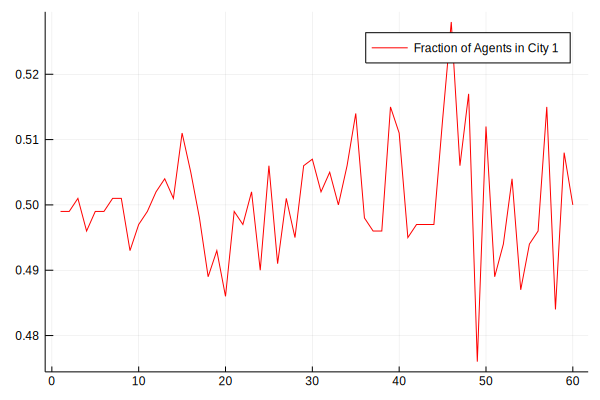

In [13]:
#=
printer(c,para)
gives fraction of agents in city 1 at any given time.
=#
function printer(c, para)
    @unpack i,σ1, σ2,w_1,w_2,r_1,r_2,β,T = para
    A= zeros(T)
    for j in 1:T
        A[j]= count(i->(0<i<=1),agent_choices(c,para)[:,j])*inv(i)
    end
    return A
end
a1= plot(printer(6, para),label="Fraction of Agents in City 1",
    title = "",color="red")
a1